## Step 2: Training a simple model

In [1]:
import os
import time
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
import torch

from wholeslidedata.interoperability.detectron2.iterator import WholeSlideDetectron2Iterator
from wholeslidedata.interoperability.detectron2.trainer import WholeSlideDectectron2Trainer
from wholeslidedata.interoperability.detectron2.predictor import Detectron2DetectionPredictor
from wholeslidedata.iterators import create_batch_iterator
from utils.vis import plot_boxes, FocalLoss

from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.modeling import build_model

from utils.loss import MyFocalROIHeads 

Setting up the training configuration and parameters (can also be defined in a separate yaml file).

In [2]:
user_config = {
    'wholeslidedata': {
        'default': {
            'yaml_source': "./configs/training_sample.yml",
            "seed": 42,
            "image_backend": "asap",
            'labels': {
                "ROI": 0,
                "lymphocytes": 1,
                "monocytes": 2
            },
        
            
            'batch_shape': {
                'batch_size': 256,
                'spacing': 0.25,
                'shape': [224,224,3],#[128,128,3],
                'y_shape': [500, 6],
            },
            
            
            
            "annotation_parser": {
                "sample_label_names": ['roi'],
            },
            
            'point_sampler_name': "RandomPointSampler",
            'point_sampler': {
                "buffer": {'spacing': "${batch_shape.spacing}", 'value': -64},
            },
            
            'patch_label_sampler_name': 'DetectionPatchLabelSampler',
            'patch_label_sampler': {
                "max_number_objects": 500,
                "detection_labels": ['lymphocytes','monocytes'],
                    
            },
            
        }
    }
}

Creating the batch generator.

In [3]:
training_batch_generator = create_batch_iterator(
    user_config=user_config,
#     user_config=r'./configs/training_config.yml',
    mode='training',
    cpus=4,
    iterator_class=WholeSlideDetectron2Iterator,
)
# validation_batch_generator = create_batch_iterator(
#     user_config=user_config,
#     mode='validation',
#     cpus=1,
#     iterator_class=WholeSlideDetectron2Iterator,
# )


Visualizing a sample batch.

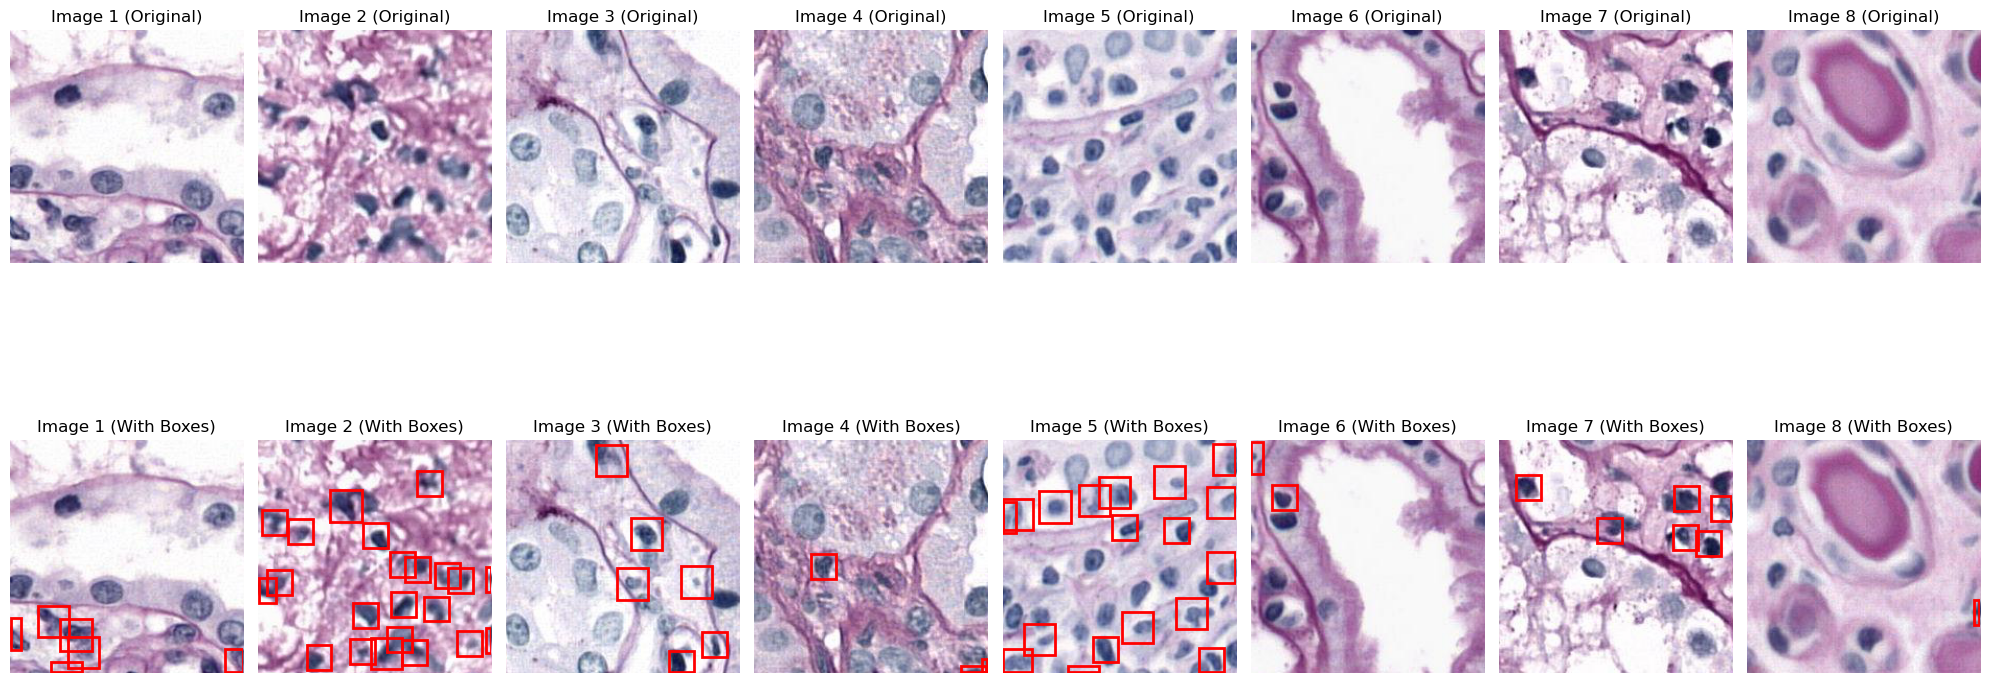

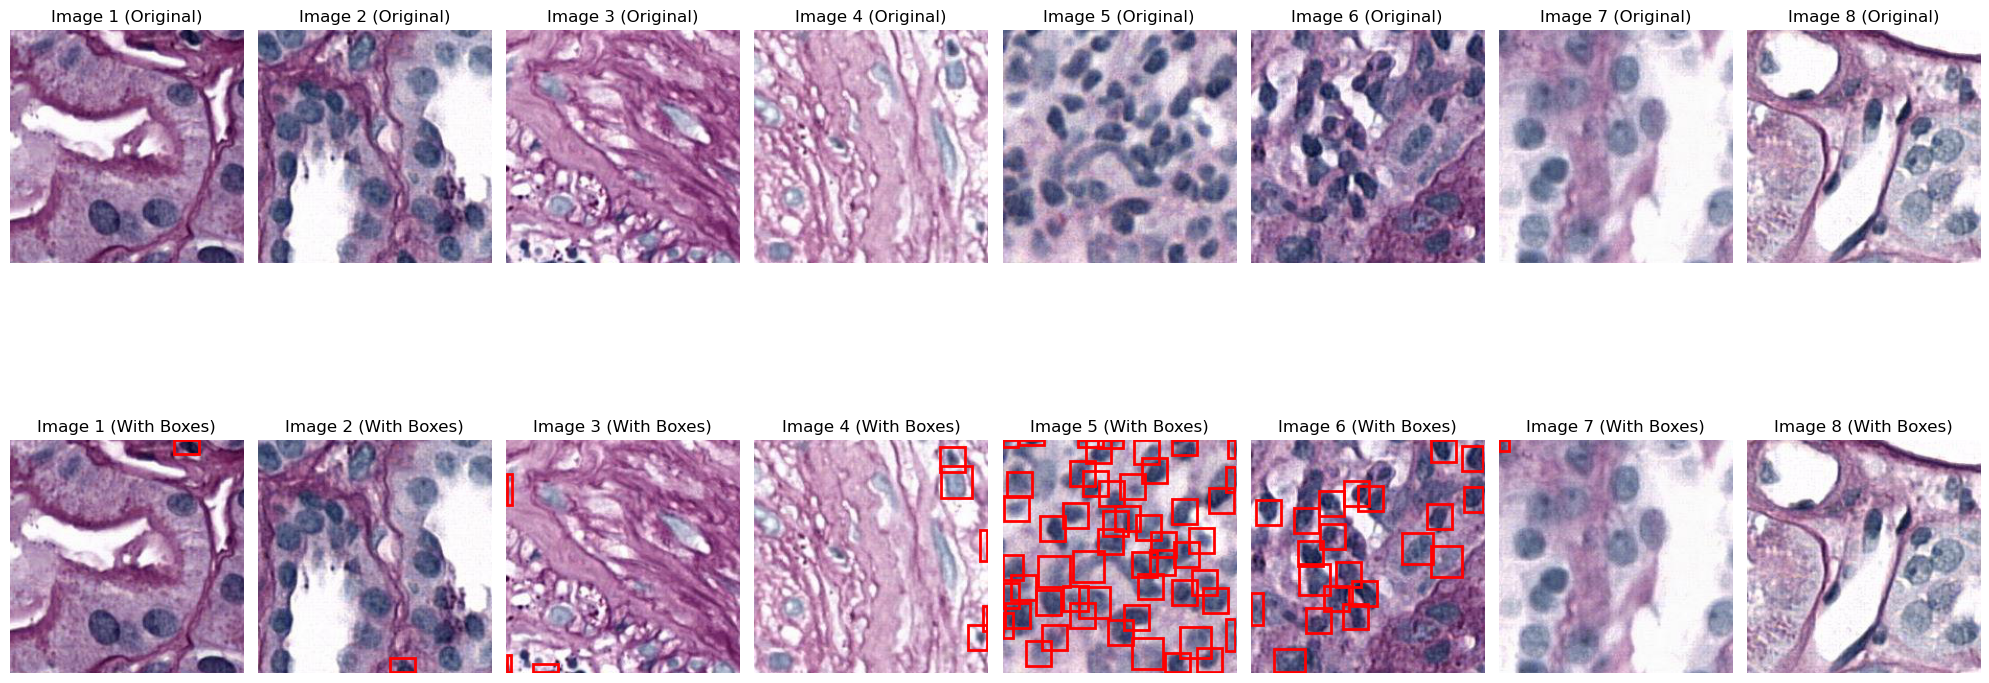

In [4]:
batch_dicts = next(training_batch_generator)

import matplotlib.pyplot as plt
import numpy as np

for _ in range(2):
    batch_dicts = next(training_batch_generator)  # トレーニング用バッチを取得
    fig, ax = plt.subplots(2, 8, figsize=(20, 10))  # 2行8列のサブプロット (元画像とボックス画像)

    for i in range(8):
        # 画像データ取得
        patch = batch_dicts[i]['image'].cpu().detach().numpy().transpose(1, 2, 0).astype('uint8')
        
        # バウンディングボックスとクラス取得
        _boxes = batch_dicts[i]['instances'].gt_boxes.tensor.cpu().detach().numpy()
        _class = batch_dicts[i]['instances'].gt_classes.cpu().detach().numpy()

        # バウンディングボックスの整形
        boxes = np.ones((len(_boxes), 6))
        boxes[..., :4] = _boxes
        max_width, max_height = batch_dicts[i]['instances'].image_size
        
        # --- 1行目: 元画像表示 ---
        ax[0, i].imshow(patch)
        ax[0, i].axis('off')  # 軸を非表示
        ax[0, i].set_title(f"Image {i+1} (Original)")

        # --- 2行目: ボックス付き画像表示 ---
        ax[1, i].imshow(patch)
        plot_boxes(boxes, max_width=max_width, max_height=max_height, axes=ax[1, i])  # ボックスを描画
        ax[1, i].axis('off')  # 軸を非表示
        ax[1, i].set_title(f"Image {i+1} (With Boxes)")

    plt.tight_layout()
    plt.show()


Creating the output folder for saving the model and results.

In [5]:
output_folder = Path('./outputs')
if not(os.path.isdir(output_folder)): os.mkdir (output_folder) 
cpus = 4

# Train the model

In [ ]:
cfg = get_cfg()
# using faster rcnn architecture
cfg.merge_from_file(
    model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")
)


cfg.DATASETS.TRAIN = ("detection_dataset2",)
cfg.DATASETS.TEST = () 
cfg.TEST.EVAL_PERIOD = 20  # 200イテレーション毎に評価を実施（例）
cfg.DATALOADER.NUM_WORKERS = 4

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[16, 24, 32]]
#cfg.MODEL.ANCHOR_GENERATOR.ASPECT_RATIOS = [[1.0]]
cfg.MODEL.ROI_HEADS.NAME = "MyFocalROIHeads"

cfg.SOLVER.IMS_PER_BATCH = 256
cfg.SOLVER.BASE_LR = 0.03  # pick a good LR
cfg.SOLVER.MAX_ITER = 1000  # 2000 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.SOLVER.STEPS = (500, 750)
cfg.SOLVER.WARMUP_ITERS = 100
cfg.SOLVER.WARMUP_FACTOR = 1.0/1000 
cfg.SOLVER.GAMMA = 0.5
cfg.SOLVER.CHECKPOINT_PERIOD = 200
cfg.SOLVER.WEIGHT_DECAY = 0.0005


cfg.INPUT.RANDOM_FLIP = "horizontal, vertical"  # "horizontal", "vertical", "none"など
cfg.INPUT.BRIGHTNESS = 0.8, 1.2
cfg.INPUT.CONTRAST = 0.8, 1.2
cfg.INPUT.SATURATION = 0.8, 1.2
cfg.INPUT.HUE = 0.8, 1.2


cfg.OUTPUT_DIR = str(output_folder)
output_folder.mkdir(parents=True, exist_ok=True)


model = build_model(cfg)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Parameter Count:\n" + str(pytorch_total_params))

from detectron2.solver.build import get_default_optimizer_params
from detectron2.solver.build import maybe_add_gradient_clipping
class MyTrainer(WholeSlideDectectron2Trainer):
    @classmethod
    def build_optimizer(cls, cfg, model):
        """
        Build an optimizer from config.
        """
        params = get_default_optimizer_params(model)
        return maybe_add_gradient_clipping(cfg, torch.optim.AdamW)(
                          params, 
                          lr=0.001,        
                          weight_decay=cfg.SOLVER.WEIGHT_DECAY)



trainer = WholeSlideDectectron2Trainer(cfg, user_config=user_config, cpus=cpus)


trainer.resume_or_load(resume=False)
trainer.train()

Parameter Count:
103967288
[12/20 00:34:40 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
 

Some model parameters or buffers are not found in the checkpoint:
backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
The checkpoint state_dict contains keys that are not used by the model:
  linear.{bias, weight}


[12/20 00:34:47 d2.engine.train_loop]: Starting training from iteration 0


/home/jubuntu/anaconda3/envs/monkey/lib/python3.10/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


ERROR [12/20 00:34:57 d2.engine.train_loop]: Exception during training:
Traceback (most recent call last):
  File "/mnt/hdd2/detectron2/detectron2/engine/train_loop.py", line 155, in train
    self.run_step()
  File "/mnt/hdd2/detectron2/detectron2/engine/defaults.py", line 530, in run_step
    self._trainer.run_step()
  File "/mnt/hdd2/detectron2/detectron2/engine/train_loop.py", line 310, in run_step
    loss_dict = self.model(data)
  File "/home/jubuntu/anaconda3/envs/monkey/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/home/jubuntu/anaconda3/envs/monkey/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
  File "/mnt/hdd2/detectron2/detectron2/modeling/meta_arch/rcnn.py", line 167, in forward
    _, detector_losses = self.roi_heads(images, features, proposals, gt_instances)
  File "/home/jubuntu/anaconda3/envs/monk

TypeError: dropout(): argument 'input' (position 1) must be Tensor, not str

Evaluation.

In [ ]:
cfg = get_cfg()

cfg.merge_from_file(
    model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")
)


cfg.DATASETS.TRAIN = ("detection_dataset2",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 1

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[8, 16, 24]]

cfg.SOLVER.IMS_PER_BATCH = 10
cfg.SOLVER.BASE_LR = 0.001  # pick a good LR
cfg.SOLVER.MAX_ITER = 2000  # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.SOLVER.WARMUP_ITERS = 0
cfg.SOLVER.GAMMA = 0.5

cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.1



cfg.OUTPUT_DIR = str(output_folder)
output_folder.mkdir(parents=True, exist_ok=True)

cfg.MODEL.WEIGHTS = os.path.join(output_folder, "model_000999.pth")

model = build_model(cfg)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Parameter Count:\n" + str(pytorch_total_params))

Parameter Count:
103967288


Visualizing a sample batch.

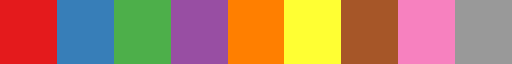

In [ ]:
plt.get_cmap('Set1')

In [ ]:
cfg

CfgNode({'VERSION': 2, 'MODEL': CfgNode({'LOAD_PROPOSALS': False, 'MASK_ON': False, 'KEYPOINT_ON': False, 'DEVICE': 'cuda', 'META_ARCHITECTURE': 'GeneralizedRCNN', 'WEIGHTS': 'outputs/model_final.pth', 'PIXEL_MEAN': [103.53, 116.28, 123.675], 'PIXEL_STD': [57.375, 57.12, 58.395], 'BACKBONE': CfgNode({'NAME': 'build_resnet_fpn_backbone', 'FREEZE_AT': 2}), 'FPN': CfgNode({'IN_FEATURES': ['res2', 'res3', 'res4', 'res5'], 'OUT_CHANNELS': 256, 'NORM': '', 'FUSE_TYPE': 'sum'}), 'PROPOSAL_GENERATOR': CfgNode({'NAME': 'RPN', 'MIN_SIZE': 0}), 'ANCHOR_GENERATOR': CfgNode({'NAME': 'DefaultAnchorGenerator', 'SIZES': [[8, 16, 24]], 'ASPECT_RATIOS': [[0.5, 1.0, 2.0]], 'ANGLES': [[-90, 0, 90]], 'OFFSET': 0.0}), 'RPN': CfgNode({'HEAD_NAME': 'StandardRPNHead', 'IN_FEATURES': ['p2', 'p3', 'p4', 'p5', 'p6'], 'BOUNDARY_THRESH': -1, 'IOU_THRESHOLDS': [0.3, 0.7], 'IOU_LABELS': [0, -1, 1], 'BATCH_SIZE_PER_IMAGE': 256, 'POSITIVE_FRACTION': 0.5, 'BBOX_REG_LOSS_TYPE': 'smooth_l1', 'BBOX_REG_LOSS_WEIGHT': 1.0, '

[12/19 21:03:55 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from outputs/model_0000999.pth ...


/home/jubuntu/anaconda3/envs/monkey/lib/python3.10/site-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_loca

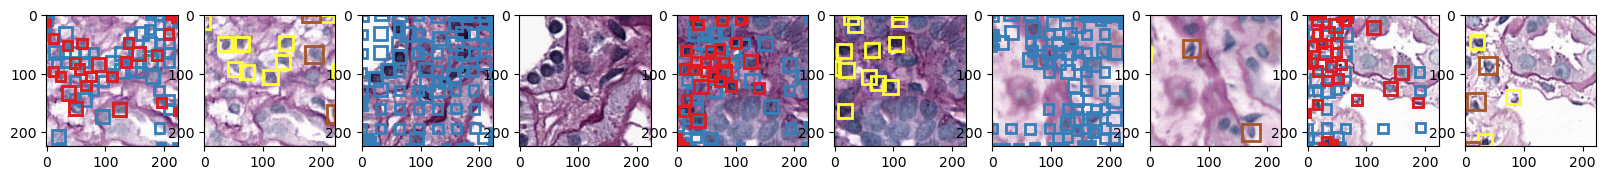

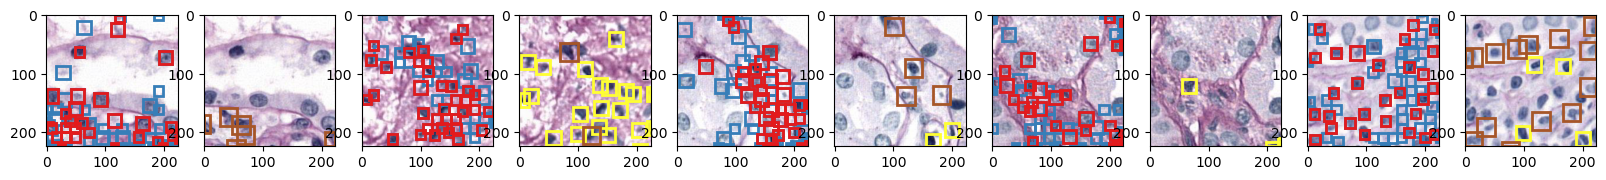

In [25]:
cfg.MODEL.WEIGHTS = os.path.join(output_folder, "model_0000999.pth")
predictor = Detectron2DetectionPredictor(cfg)
class_threshold = [0.3, 0.3]#lymph, mono
with create_batch_iterator(
    user_config=user_config,
    mode='training',
    cpus=4,
) as training_batch_generator:
    for _ in range(2):
        fig, ax = plt.subplots(1,10, figsize=(20,10))
        batch_x, batch_y, info = next(training_batch_generator)
        predicted_batch = predictor.predict_on_batch(batch_x)
        for i in range(5):
            patch = batch_x[i]
            boxes =  np.array(predicted_batch[i]['boxes'])
            confidences = predicted_batch[i]['confidences']
            classes = predicted_batch[i]['classes'] 
            boxes[:, 4] = list(np.array(classes))
            
            gt_boxes = batch_y[i]
            gt_boxes[:, 4] +=4

            filtered_boxes = []
            filtered_boxes_gt = []
            for box, confidence, cls in zip(boxes, confidences, classes):
                if confidence > class_threshold[cls]:
                    filtered_boxes.append(box)
            for gt_box in gt_boxes:
                filtered_boxes_gt.append(gt_box)

            ax[2*i].imshow(patch)
            plot_boxes(filtered_boxes, max_width=64, max_height=64, axes=ax[2*i],color_map=plt.get_cmap('Set1'))
            ax[2*i+1].imshow(patch)
            plot_boxes(filtered_boxes_gt, max_width=64, max_height=64, axes=ax[2*i+1],color_map=plt.get_cmap('Set1'))
        plt.show()